In [1]:
import lightning as L
import torch
import torchvision
import torch.nn as nn
import torch.nn.functional as F

from torch.utils.data import DataLoader
from  torchvision import transforms
from torchvision.datasets import MNIST

import matplotlib.pyplot as plt

### Load Data

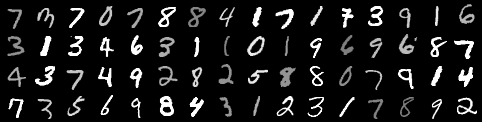

In [2]:
# Data Preprocessing

transform = transforms.Compose([transforms.ToTensor(), transforms.ColorJitter(brightness=.5, hue=.3)])
train_dataset = MNIST(root=".././data", train=True, download=True, transform=transform)
train_set, val_set = torch.utils.data.random_split(train_dataset, [55000, 5000])
test_set = MNIST(root=".././data", train=False, download=True, transform=transform)

train_loader = DataLoader(train_set, batch_size=256, drop_last=True, shuffle=True, num_workers=4)
val_loader = DataLoader(val_set, batch_size=256, shuffle=False, num_workers=4)
test_loader = DataLoader(test_set, batch_size=256, shuffle=False, num_workers=4)

grid_img = torchvision.utils.make_grid(next(iter(train_loader))[0][:64], nrow=16)
transforms.ToPILImage()(grid_img)

In [214]:
class AddGaussianNoise(object):
    def __init__(self, mean=0., std=1.):
        self.std = std
        self.mean = mean
        
    def __call__(self, tensor):
        std = torch.rand(1, device=tensor.device) * self.std
        return tensor + torch.randn(tensor.size(), device=tensor.device) * std + self.mean
    
    def __repr__(self):
        return self.__class__.__name__ + '(mean={0}, std={1})'.format(self.mean, self.std)

class VAE(L.LightningModule):
    def __init__(self, latent_dim=16, gaussian_noise=0.0):
        super().__init__()
        self.save_hyperparameters()

        act_fn = nn.ReLU

        self.encoder = nn.Sequential(
            nn.Conv2d(1, 32, kernel_size=3, padding=1, stride=2),  # 1x28x28 -> 32x14x14
            act_fn(),
            nn.Conv2d(32, 32, kernel_size=3, padding=1),  # 32x14x14 -> 32x14x14
            act_fn(),
            nn.Conv2d(32, 64, kernel_size=3, padding=1, stride=2),  # 32x14x14 -> 64x7x7
            act_fn(),
            nn.Conv2d(64, 64, kernel_size=3, padding=1, stride=2),  # 64x7x7 -> 64x4x4
            act_fn(),
            nn.Flatten(),  # 64x4x4 -> 1024
        )        

        self.decoder = nn.Sequential(
            nn.Linear(latent_dim, 16 * 64),  # latent_dim -> 1024
            act_fn(),
            nn.Unflatten(1, (64, 4, 4)),  # 1024 -> 64x4x4
            nn.ConvTranspose2d(64, 64, kernel_size=3, output_padding=0, padding=1, stride=2, dilation=1),  # 64x4x4 -> 64x7x7
            act_fn(),
            nn.ConvTranspose2d(64, 32, kernel_size=3, output_padding=1, padding=1, stride=2, dilation=1),  # 64x7x7 -> 32x14x14
            act_fn(),
            nn.Conv2d(32, 32, kernel_size=3, stride=1, padding=1),  # 32x14x14 -> 32x14x14
            act_fn(),
            nn.ConvTranspose2d(32, 1, kernel_size=3, output_padding=1, padding=1, stride=2, dilation=1),  # 32x14x14 -> 1x28x28
            nn.Tanh(), # or Sigmoid?
        )

        self.fc_mu = nn.Linear(1024, latent_dim) # 1024 -> latent_dim
        self.fc_var = nn.Linear(1024, latent_dim)

        self.log_scale = nn.Parameter(torch.Tensor([0.0]))

        self.noise = AddGaussianNoise(mean=0, std=gaussian_noise)

    def forward(self, x):
        x = self.encoder(x)
        mu, log_var = self.fc_mu(x), self.fc_var(x)
        x = torch.distributions.Normal(mu, torch.exp(log_var / 2)).rsample()
        x = self.decoder(x)
        return x

    def configure_optimizers(self):
        return torch.optim.Adam(self.parameters(), lr=1e-3)

    def gaussian_likelihood(self, mean, logscale, sample):
        scale = torch.exp(logscale)
        dist = torch.distributions.Normal(mean, scale)
        log_pxz = dist.log_prob(sample)
        return log_pxz.sum(dim=(1, 2, 3))

    # def kl_divergence_gaussian(self, z, mu, log_var):
    #     return -0.5 * torch.sum(1 + log_var - mu.pow(2) - log_var.exp(), dim=1)

    def kl_divergence(self, z, mu, std):
        p = torch.distributions.Normal(torch.zeros_like(mu), torch.ones_like(std))
        q = torch.distributions.Normal(mu, std)

        return torch.sum(q.log_prob(z) - p.log_prob(z), dim=1)

    def training_step(self, batch, batch_idx):
        x, _ = batch
        x = self.noise(x)

        x_encoded = self.encoder(x)
        mu, log_var = self.fc_mu(x_encoded), self.fc_var(x_encoded)

        std = torch.exp(log_var / 2)
        q = torch.distributions.Normal(mu, std)
        z = q.rsample()

        x_hat = self.decoder(z)

        recon_loss = self.gaussian_likelihood(x_hat, self.log_scale, x)
        kl_div = self.kl_divergence(z, mu, std)  # KL divergence
        loss = (kl_div - recon_loss).mean()  # elbo

        self.log("train_loss", loss, prog_bar=True)
        self.log_dict({
                "recon_loss": recon_loss.mean(),
                "kl_div": kl_div.mean(),
                "elbo": loss,
        })
        return loss



In [215]:
LATENT_DIM = 8
NUM_EPOCHS = 10
GAUSSIAN_NOISE = 0.5

trainer = L.Trainer(
    enable_checkpointing=False,
    logger=False,
    accelerator="auto",
    devices=1,
    max_epochs=NUM_EPOCHS,
)

model=VAE(latent_dim=LATENT_DIM, gaussian_noise=GAUSSIAN_NOISE)
trainer.fit(model, train_loader, val_loader)

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name         | Type       | Params
--------------------------------------------
0 | encoder      | Sequential | 65.0 K
1 | decoder      | Sequential | 74.1 K
2 | fc_mu        | Linear     | 8.2 K 
3 | fc_var       | Linear     | 8.2 K 
  | other params | n/a        | 1     
--------------------------------------------
155 K     Trainable params
0         Non-trainable params
155 K     Total params
0.622     Total estimated model params size (MB)


Epoch 9: 100%|██████████| 214/214 [00:04<00:00, 47.61it/s, train_loss=397.0]

`Trainer.fit` stopped: `max_epochs=10` reached.


Epoch 9: 100%|██████████| 214/214 [00:04<00:00, 47.59it/s, train_loss=397.0]


### Reconstruction (Autoencoding)

In [216]:
NUM_SAMPLES = 8

In [217]:
def visualize_reconstructions(model, input_imgs):
    # Reconstruct images
    model.eval()
    with torch.no_grad():
        reconst_imgs = model(input_imgs.to(model.device))
    reconst_imgs = reconst_imgs.cpu()

    # Plotting
    imgs = torch.stack([input_imgs, reconst_imgs], dim=1).flatten(0, 1)
    grid = torchvision.utils.make_grid(imgs, nrow=8, normalize=True)
    grid = grid.permute(1, 2, 0)
    
    plt.figure(figsize=(10, 5))
    plt.imshow(grid)
    plt.axis("off")
    plt.show()

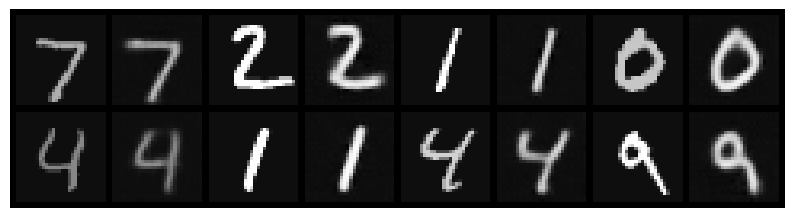

In [218]:
# 0% noise
input_imgs = next(iter(test_loader))[0][:NUM_SAMPLES]
visualize_reconstructions(model, input_imgs)

### Denoising

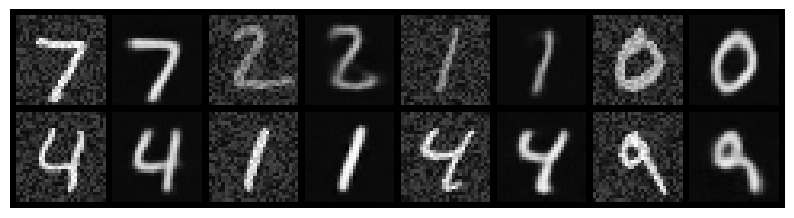

In [219]:
# 25% noise
input_imgs = 0.75 * next(iter(test_loader))[0][:NUM_SAMPLES] + 0.25 * torch.rand(NUM_SAMPLES, 1, 28, 28)
visualize_reconstructions(model, input_imgs)

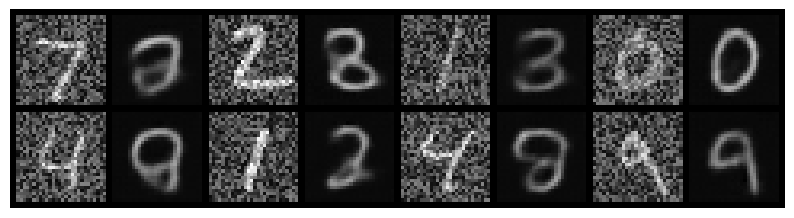

In [220]:
# 50% noise
input_imgs = 0.5 * next(iter(test_loader))[0][:NUM_SAMPLES] + 0.5 * torch.rand(NUM_SAMPLES, 1, 28, 28)
visualize_reconstructions(model, input_imgs)

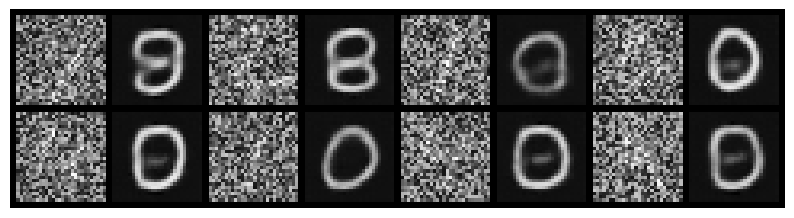

In [221]:
# 75% noise
input_imgs = 0.25 * next(iter(test_loader))[0][:NUM_SAMPLES] + 0.75 * torch.rand(NUM_SAMPLES, 1, 28, 28)
visualize_reconstructions(model, input_imgs)

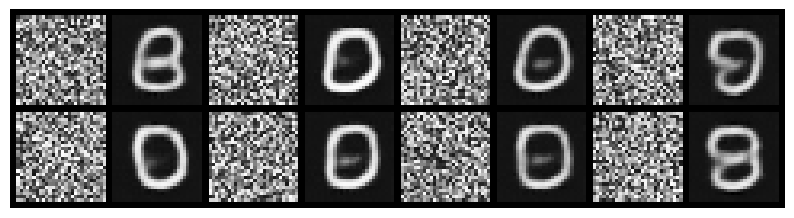

In [222]:
# 100% noise
input_imgs = torch.rand(NUM_SAMPLES, 1, 28, 28)
visualize_reconstructions(model, input_imgs)

### Generation (Sampling from Latent Space)

In [224]:
def generate_new_images(model, latent_vectors):
    model.eval()
    latent_vectors.to(device=model.device)
    with torch.no_grad():
        imgs = model.decoder(latent_vectors)
        imgs = imgs.cpu()

    grid = torchvision.utils.make_grid(imgs, nrow=8, normalize=True, pad_value=0.5)
    grid = grid.permute(1, 2, 0)
    plt.figure(figsize=(10, 5))
    plt.imshow(grid)
    plt.axis("off")
    plt.show()

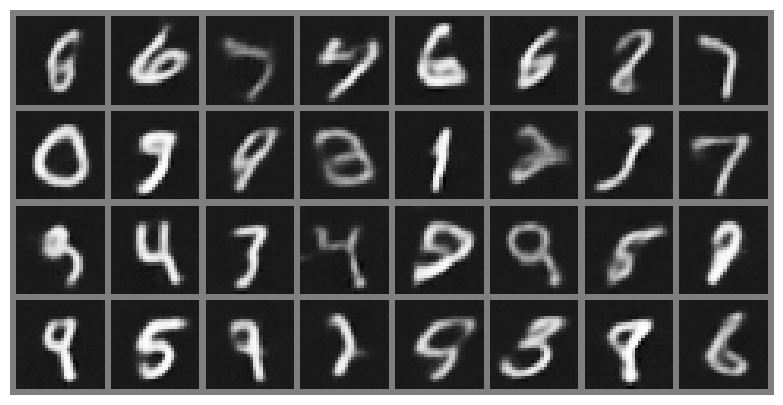

In [228]:
random_vectors = torch.randn(4 * NUM_SAMPLES, LATENT_DIM)
generate_new_images(model, random_vectors)